In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag

from scipy.signal import savgol_filter
%matplotlib inline

def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
ls

bag_output_ukf_polban0807_02.bag  waypoints.ipynb  waypoints.png


In [3]:
bag = rosbag.Bag('bag_output_ukf_polban0807_02.bag')
bag.get_type_and_topic_info()

TypesAndTopicsTuple(msg_types={'diagnostic_msgs/DiagnosticArray': '60810da900de1dd6ddd437c3503511da', 'dynamic_reconfigure/Config': '958f16a05573709014982821e6822580', 'dynamic_reconfigure/ConfigDescription': '757ce9d44ba8ddd801bb30bc456f946f', 'geometry_msgs/TwistStamped': '98d34b0043a2093cf9d9345ab6eef12e', 'nav_msgs/Odometry': 'cd5e73d190d741a2f92e81eda573aca7', 'rosgraph_msgs/Log': 'acffd30cd6b6de30f120938c17c593fb', 'sensor_msgs/Imu': '6a62c6daae103f4ff57a132d6f95cec2', 'sensor_msgs/NavSatFix': '2d3a8cd499b9b4a0249fb98fd05cfa48', 'sensor_msgs/TimeReference': 'fded64a0265108ba86c3d38fb11c0c16', 'tf2_msgs/TFMessage': '94810edda583a504dfda3829e70d7eec'}, topics={'/diagnostics': TopicTuple(msg_type='diagnostic_msgs/DiagnosticArray', message_count=767, connections=3, frequency=3.8358004961304113), '/fix': TopicTuple(msg_type='sensor_msgs/NavSatFix', message_count=1069, connections=1, frequency=4.9971185848004005), '/gps/filtered': TopicTuple(msg_type='sensor_msgs/NavSatFix', message_co

# Versi 1

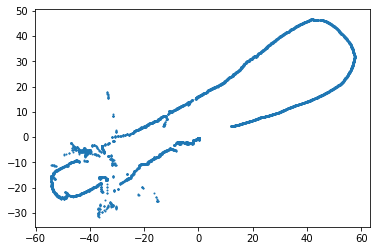

In [4]:
X_fm = []
cov_pose_fm = []
ttime = []
for topic, msg, t in bag.read_messages(topics=['/odometry/filtered_map']):
    X_fm.append([msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z])
    cov_pose_fm.append(msg.pose.covariance)
    ttime.append(msg.header.stamp.secs + msg.header.stamp.nsecs / 1e9)

ttime = np.array(ttime) - ttime[0]
X_fm = np.array(X_fm)
cov_pose_fm = np.array(cov_pose_fm)

plt.scatter(X_fm[:,0], X_fm[:,1], s=1.)
plt.show()

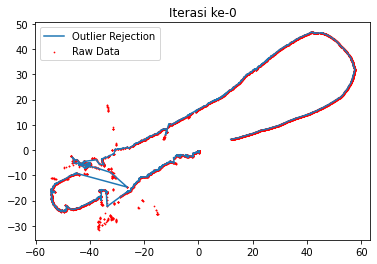

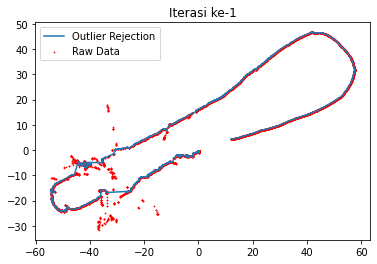

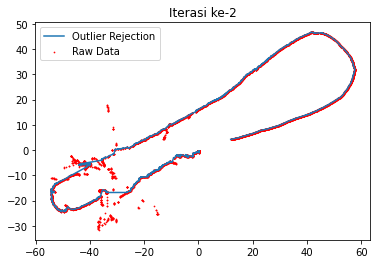

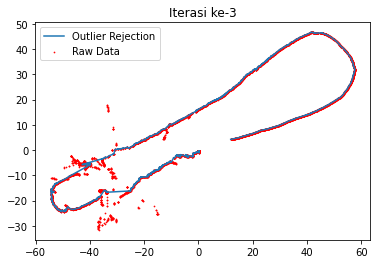

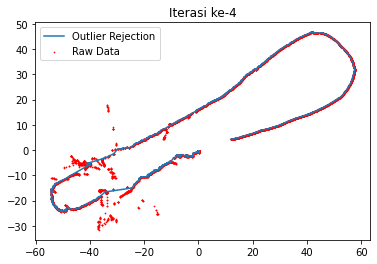

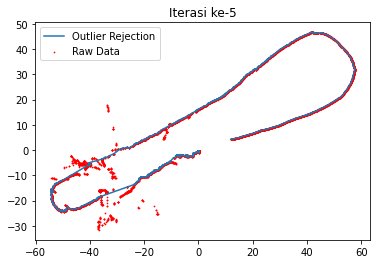

In [5]:
# Filter the waypoints and remove the outlier !
X_in = np.copy(X_fm)
t_in = np.copy(ttime)

for m in range(6):
    X_in_filtered = np.empty(X_in.shape)
    dt = np.empty(X_in.shape[0])
    dt[:-1] = t_in[1:] - t_in[:-1]
    dt[-1] = dt[-2]
    for i in range(3):
        X_in_filtered[:,i] = savgol_filter(X_in[:,i], 101, 3, delta=1.)
    dist = np.sqrt(np.sum((X_in_filtered[:, :2] - X_in[:, :2])**2, axis=-1))
    X_in = X_in[dist <= 1., :]
    t_in = t_in[dist <= 1.]
    if m % 1 == 0:
        plt.scatter(X_fm[:,0], X_fm[:,1], label='Raw Data', s=0.5,color='red')
        plt.plot(X_in[:,0], X_in[:,1], label='Outlier Rejection')
        plt.legend()
        plt.title('Iterasi ke-{}'.format(m))
        plt.show()

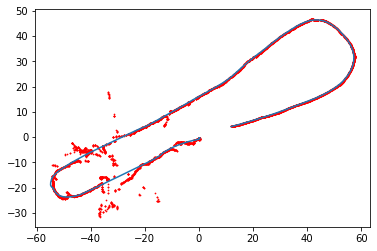

In [6]:
X_in_filtered = np.empty(X_in.shape)
for i in range(3):
    X_in_filtered[:,i] = savgol_filter(X_in[:,i], 501, 3)
plt.plot(X_in_filtered[:,0], X_in_filtered[:,1])
plt.scatter(X_fm[:,0], X_fm[:,1], color='red',s=0.5)

Karena sangat NOISY di bagian YAW, Waypoint dibuat untuk setiap 0.5 meter saja

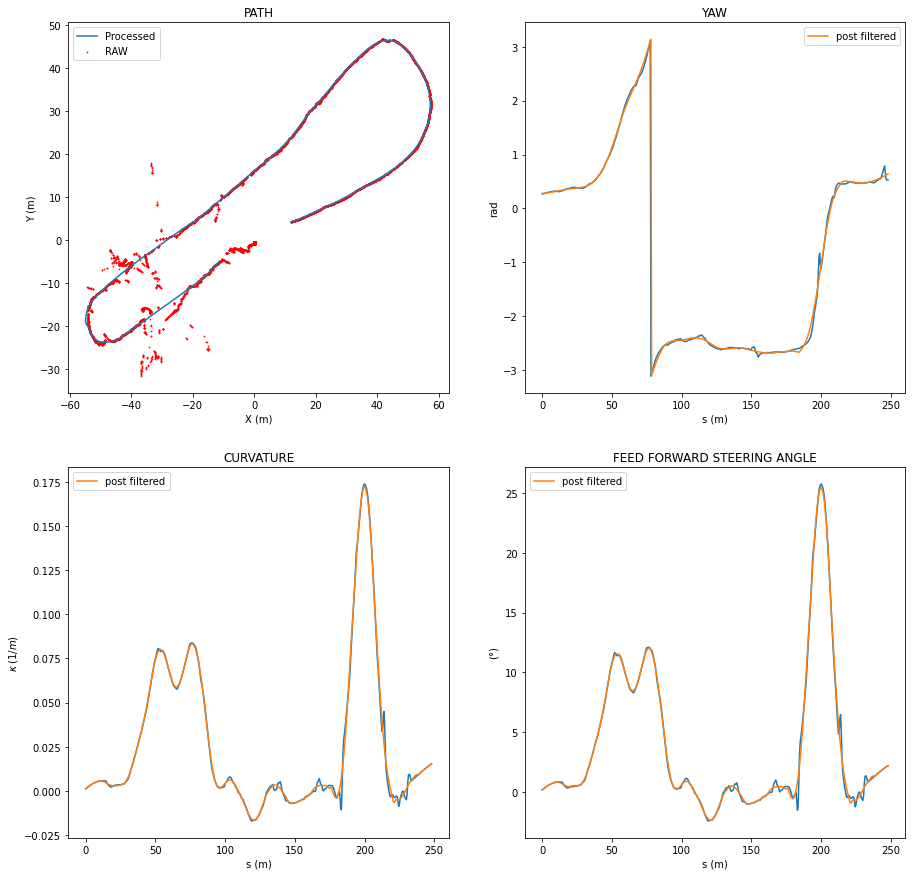

In [7]:
dst = 0.5
wp = [X_in_filtered[0]]
for i in range(1, X_in_filtered.shape[0]-2000):
    dist = np.linalg.norm(X_in_filtered[i] - wp[-1])
    if dist >= dst:
        wp.append(wp[-1] + dst/dist*(X_in_filtered[i] - wp[-1]))
wp = np.array(wp)
yaw = np.empty(wp.shape[0])
yaw[1:-1] = np.arctan2(wp[2:, 1] - wp[:-2, 1], wp[2:, 0] - wp[:-2, 0])
yaw[0] = yaw[1]; yaw[-1] = yaw[-2]
yawf = wrap_angle(savgol_filter(np.unwrap(yaw), 61, 3, delta=1.))

s = np.zeros(wp.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.linalg.norm(wp[i] - wp[i-1])

curvature = np.gradient(np.unwrap(yawf), s)
curvaturef = savgol_filter(curvature, 31, 3, delta=1.)
steer = np.arcsin(2.5 * curvature)*180/np.pi
steerf = savgol_filter(steer, 31, 3, delta=1.)

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(2,2,1)
plt.plot(wp[:,0], wp[:,1], label='Processed')
plt.scatter(X_fm[:,0], X_fm[:,1], color='red',s=0.5, label='RAW')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")

plt.subplot(2,2,2)
plt.plot(s, yaw)
plt.plot(s, yawf, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel('rad')
plt.legend()

plt.subplot(2,2,3)
plt.plot(s, curvature)
plt.plot(s, curvaturef, label='post filtered')
plt.legend()
plt.title("CURVATURE")
plt.xlabel('s (m)')
plt.ylabel(r'$\kappa\;(1/m)$')

plt.subplot(2,2,4)
plt.plot(s, steer)
plt.plot(s, steerf, label='post filtered')
plt.legend()
plt.title("FEED FORWARD STEERING ANGLE")
plt.xlabel('s (m)')
plt.ylabel(r'$(\degree)$')

plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()

# INTERPOLATING THE WAYPOINTS

In [8]:
# Generate the velocity
v0 = 1. #m/s ~ 3.6 km/jam
vmax = 2. #m/s ~ 7.2 km/jam
accel = 0.2 #m/s2
num = wp.shape[0]
vel = [v0]
for i in range(1, num):
    vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax))
vel = np.array(vel)

In [9]:
waypoints_np = np.empty((wp.shape[0], 5))
waypoints_np[:,0] = wp[:,0]
waypoints_np[:,1] = wp[:,1]
waypoints_np[:,2] = yawf
waypoints_np[:,3] = vel
waypoints_np[:,4] = curvaturef

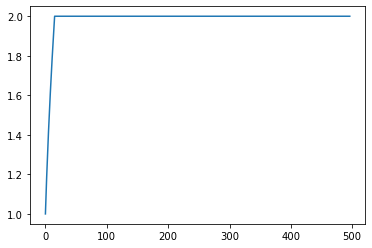

In [13]:
plt.plot(waypoints_np[:,3])

In [11]:
INTERP_DISTANCE_RES = 0.05 # distance between interpolated points

# Linear interpolation computations
# Compute a list of distances between waypoints
wp_distance = []   # distance array
for i in range(1, waypoints_np.shape[0]):
    wp_distance.append(
            np.sqrt((waypoints_np[i, 0] - waypoints_np[i-1, 0])**2 +
                    (waypoints_np[i, 1] - waypoints_np[i-1, 1])**2))
wp_distance.append(0)  # last distance is 0 because it is the distance
                       # from the last waypoint to the last waypoint

# Linearly interpolate between waypoints and store in a list
wp_interp      = []    # interpolated values 
                       # (rows = waypoints, columns = [x, y, v])
wp_interp_hash = []    # hash table which indexes waypoints_np
                       # to the index of the waypoint in wp_interp
interp_counter = 0     # counter for current interpolated point index
for i in range(waypoints_np.shape[0] - 1):
    # Add original waypoint to interpolated waypoints list (and append
    # it to the hash table)
    wp_interp.append(list(waypoints_np[i]))
    wp_interp_hash.append(interp_counter)   
    interp_counter+=1

    # Interpolate to the next waypoint. First compute the number of
    # points to interpolate based on the desired resolution and
    # incrementally add interpolated points until the next waypoint
    # is about to be reached.
    num_pts_to_interp = int(np.floor(wp_distance[i] /\
                                 float(INTERP_DISTANCE_RES)) - 1)
    wp_vector = waypoints_np[i+1] - waypoints_np[i]
    wp_uvector = wp_vector / np.linalg.norm(wp_vector)
    for j in range(num_pts_to_interp):
        next_wp_vector = INTERP_DISTANCE_RES * float(j+1) * wp_uvector
        wp_interp.append(list(waypoints_np[i] + next_wp_vector))
        interp_counter+=1
# add last waypoint at the end
wp_interp.append(list(waypoints_np[-1]))
wp_interp_hash.append(interp_counter)   
wp_interp = np.array(wp_interp)
wp_interp_hash = np.array(wp_interp_hash)
interp_counter+=1

In [12]:
np.save('waypoints', waypoints_np)
np.save('waypoints_interpolated', wp_interp)

# Versi 2

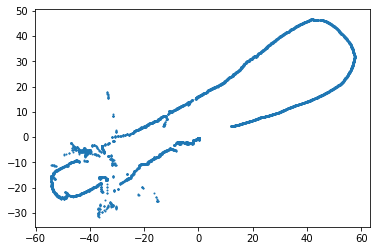

In [51]:
X_fm = []
cov_pose_fm = []
ttime = []
for topic, msg, t in bag.read_messages(topics=['/odometry/filtered_map']):
    X_fm.append([msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z])
    cov_pose_fm.append(msg.pose.covariance)
    ttime.append(msg.header.stamp.secs + msg.header.stamp.nsecs / 1e9)

ttime = np.array(ttime) - ttime[0]
X_fm = np.array(X_fm)
cov_pose_fm = np.array(cov_pose_fm)

plt.scatter(X_fm[:,0], X_fm[:,1], s=1.)
plt.show()

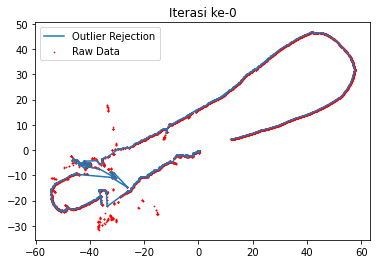

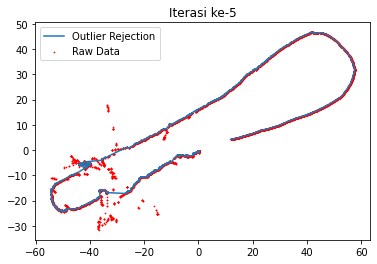

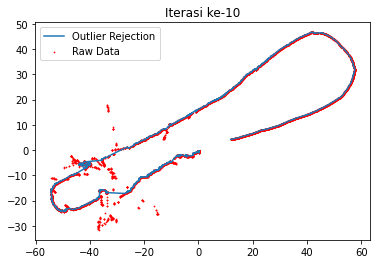

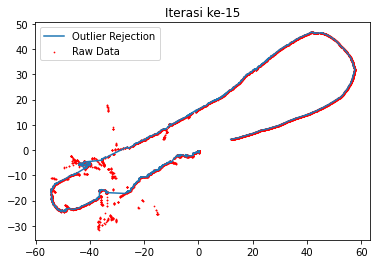

In [61]:
# Filter the waypoints and remove the outlier !
X_in = np.copy(X_fm)
t_in = np.copy(ttime)

for m in range(16):
    X_in_filtered = np.empty(X_in.shape)
    dt = np.empty(X_in.shape[0])
    dt[:-1] = t_in[1:] - t_in[:-1]
    dt[-1] = dt[-2]
    for i in range(3):
        X_in_filtered[:,i] = savgol_filter(X_in[:,i], 101, 3, delta=1.)
    dist = np.empty(X_in.shape[0])
    for i in range(dist.shape[0]):
        temp = np.sqrt(np.sum((X_in_filtered[:, :2] - X_in[i, :2])**2, axis=-1))
        dist[i] = np.min(temp)
    X_in = X_in[dist <= .5, :]
    t_in = t_in[dist <= .5]
    if m % 5 == 0:
        plt.scatter(X_fm[:,0], X_fm[:,1], label='Raw Data', s=0.5,color='red')
        plt.plot(X_in[:,0], X_in[:,1], label='Outlier Rejection')
        plt.legend()
        plt.title('Iterasi ke-{}'.format(m))
        plt.show()

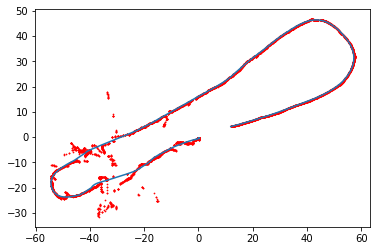

In [63]:
X_in_filtered = np.empty(X_in.shape)
for i in range(3):
    X_in_filtered[:,i] = savgol_filter(X_in[:,i], 501, 3)
plt.plot(X_in_filtered[:,0], X_in_filtered[:,1])
plt.scatter(X_fm[:,0], X_fm[:,1], color='red',s=0.5)

Karena sangat NOISY di bagian YAW, Waypoint dibuat untuk setiap 1 meter saja

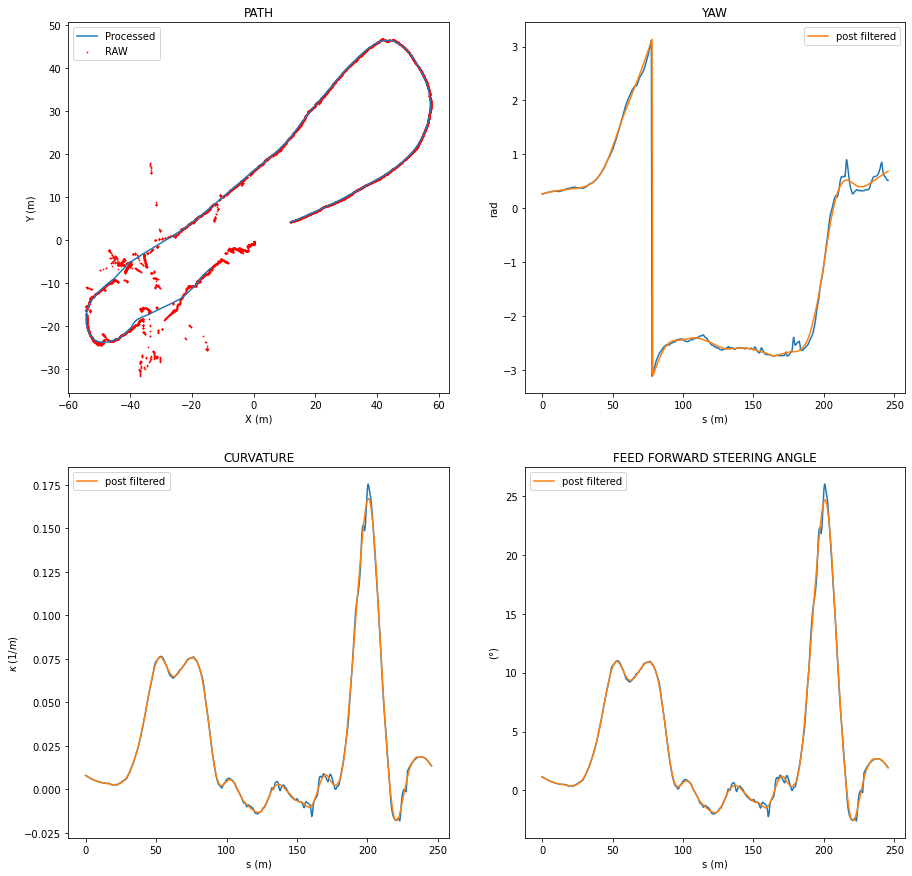

In [65]:
dst = 0.5
wp = [X_in_filtered[0]]
for i in range(1, X_in_filtered.shape[0]-2000):
    dist = np.linalg.norm(X_in_filtered[i] - wp[-1])
    if dist >= dst:
        wp.append(wp[-1] + dst/dist*(X_in_filtered[i] - wp[-1]))
wp = np.array(wp)
yaw = np.empty(wp.shape[0])
yaw[1:-1] = np.arctan2(wp[2:, 1] - wp[:-2, 1], wp[2:, 0] - wp[:-2, 0])
yaw[0] = yaw[1]; yaw[-1] = yaw[-2]
yawf = wrap_angle(savgol_filter(np.unwrap(yaw), 71, 3, delta=1.))

s = np.zeros(wp.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.linalg.norm(wp[i] - wp[i-1])

curvature = np.gradient(np.unwrap(yawf), s)
curvaturef = savgol_filter(curvature, 31, 3, delta=1.)
steer = np.arcsin(2.5 * curvature)*180/np.pi
steerf = savgol_filter(steer, 31, 3, delta=1.)

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(2,2,1)
plt.plot(wp[:,0], wp[:,1], label='Processed')
plt.scatter(X_fm[:,0], X_fm[:,1], color='red',s=0.5, label='RAW')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")

plt.subplot(2,2,2)
plt.plot(s, yaw)
plt.plot(s, yawf, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel('rad')
plt.legend()

plt.subplot(2,2,3)
plt.plot(s, curvature)
plt.plot(s, curvaturef, label='post filtered')
plt.legend()
plt.title("CURVATURE")
plt.xlabel('s (m)')
plt.ylabel(r'$\kappa\;(1/m)$')

plt.subplot(2,2,4)
plt.plot(s, steer)
plt.plot(s, steerf, label='post filtered')
plt.legend()
plt.title("FEED FORWARD STEERING ANGLE")
plt.xlabel('s (m)')
plt.ylabel(r'$(\degree)$')

plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()